# *Supersingular isogeny key exchange for beginners* in Sage
The paper [Supersingular isogeny key exchange
for beginners](https://eprint.iacr.org/2019/1321.pdf) by Craig Costello is a great starting point for isogeny-based cryptography. It describes how the supersingular isogeny Diffie-Hellman (SIDH) protocol works by means of a toy example. 

In this notebook I'll run through the same example using Sage. Readers of the paper can use this notebook to play with the mathematical objects and get a better grasp on how they behave. 

This is the first part of a series of posts/notebooks I am writing on isogeny-based crypto. They will all be available on [my blog](https://solvable.group/posts).

## Setup
The paper works with the field $\mathbb{F}_{p^2}=\mathbb{F}_p[i]$ with $p = 431$ and $i^2 + 1 = 0$.

In [1]:
p = 431
K.<i> = GF(p^2, 'i', modulus=x^2 + 1)

# Finding $j$-invariants
The paper gives us the set of 37 supersingular $j$-invariants in $\mathbb{F}_{p^2}$. But how do we find them? One way is to use *Theorem 4.1.b* of Silverman's *The Arithmetic of Elliptic Curves*, which says the following:

> Let $m = (p-1)/2$ and $H_p(t)=\sum_{i=0}^m \binom{m}{i}^2 t^i$, then for $0, 1\ne \lambda \in \bar{\mathbb{F}}_p$, we have $H_p(\lambda)=0$ if and only if $E_\lambda: y^2 = x(x-1)(x-\lambda)$ is supersingular.

The proof further shows that all isomorphism classes of supersingular elliptic curves (and thus of $j$-invariants) are represented by some $E_\lambda$. 

Computing the set of $j$-invariants is then straightforward. We just have to compute $j(E_\lambda)$ for all roots $\lambda$ of $H_p(t)$:

In [2]:
# Set up the polynomial ring
PR.<t> = K[]
# Compute the H_p(t) polynomial
def H_p(t):
    m = (p-1)//2
    return sum([binomial(m, i)^2 * t^i for i in range(m+1)])

# Compute the roots of H_p(t)
lambdas = [r[0] for r in H_p(t).roots() if r[0] not in [0,1]]

# Initialize the set of j-invariants
js = set()
# We'll keep track of each curves and their corresponding j-invariant in this dic.
Es = {}

for lambda_ in lambdas:
    # E: y^2 = x(x-1)(x-lambda)
    E = EllipticCurve(K, [0, K(-lambda_-1), 0, lambda_, 0])
    j = E.j_invariant()
    js.add(j)
    Es[j] = E

print(len(js))
print(js)

37
{0, 4, 42*i + 141, 67*i + 304, 125*i + 426, 143, 350*i + 65, 19, 150, 81*i + 65, 419, 422, 106*i + 379, 389*i + 141, 316, 299*i + 315, 61, 319, 189, 67, 222*i + 118, 87*i + 190, 209*i + 118, 344*i + 190, 132*i + 315, 356, 364*i + 304, 102, 358, 325*i + 379, 234, 107, 306*i + 426, 241, 242, 381, 125}


And we get back the set of 37 $j$-invariants given in the paper.

## Isogenies
The paper mentions the following powerfull theorem:

> Separable isogenies of degree $d$ with domain $E$ are in one-to-one correspondance with subgroups of $E$ of order $d$.

Sage makes it very easy to use this correspondance. Given a point $P\in E$, `phi = E.isogeny(P)` returns the isogeny corresponding to $\langle P \rangle$, and `phi.codomain()` returns the codomain curve $E/\langle P \rangle$:

In [3]:
P = E.random_point()
phi = E.isogeny(P)
phi.codomain()

Elliptic Curve defined by y^2 = x^3 + (386*i+429)*x^2 + (393*i+193)*x + (45*i+223) over Finite Field in i of size 431^2

The SIDH protocol works by considering of order $\ell$, for $\ell$ a small prime (usually $2$ or $3$).

Now to compute all $\ell$-isogenies, we need to find distinct subgroups of order $\ell$. 

Remember that we have that $$E \cong \mathbb{Z}/(p+1)\mathbb{Z} \times \mathbb{Z}/(p+1)\mathbb{Z}$$ as abelian groups. Let $\tilde{P}, \tilde{Q}$ be generators of this group (corresponding to $(1,0)$ and $(0,1)$), computable with $\tilde{P}, \tilde{Q} = E.gens()$. Then $$P = \left((p+1)/\ell\right) \cdot \tilde{P} \text{ and } Q = \left((p+1)/\ell\right) \cdot \tilde{Q}$$ are generators of $E[\ell] \cong \mathbb{Z}/\ell\mathbb{Z} \times \mathbb{Z}/\ell\mathbb{Z}$.

Finally, we can compute generators of subgroups of order $\ell$, for $\ell\in\{2,3\}$:
- For $\ell=2$, they are $P, Q$ and $P+Q$.
- For $\ell=3$, they are $P, Q, P+Q$ and $2P + Q$.

In [4]:
def subgroup_gen(E, l):
     Ptilde, Qtilde = E.gens()
     P, Q = ((p+1)//l) * Ptilde, ((p+1)//l) * Qtilde
     if l == 2:
         return [P, Q, P+Q]
     elif l == 3:
         return [P, Q, P+Q, 2*P + Q]

In [5]:
E = list(Es.values())[23]
print(f"Generators of the subgroups of order 2: {subgroup_gen(E,2)}")
print(f"Generators of the subgroups of order 3: {subgroup_gen(E,3)}")

Generators of the subgroups of order 2: [(1 : 0 : 1), (251*i + 23 : 0 : 1), (0 : 0 : 1)]
Generators of the subgroups of order 3: [(237*i + 363 : 371*i + 70 : 1), (417*i + 233 : 157*i + 91 : 1), (30*i + 360 : 205*i + 187 : 1), (369*i + 369 : 417*i + 207 : 1)]


## Isogeny graph
We now have all the tools available to build the isogeny graph for $\ell= 2,3$. For each $j$-invariant $j$, we have to:
1. Get a curve $E$, with $j(E)=j$. That's exactly what the dictionnary `Es` is for.
2. Compute generators $\{P_i\}_{i=0}^\ell$ for the subgroups of order $\ell$. That's what the function `subgroup_gen` does.
3. Compute the corresponding isogenies $\{\phi_i\}_{i=0}^\ell$ and their codomains $\{E_i\}_{i=0}^\ell$.
4. Compute the $j$-invariants $\{j(E_i)\}_{i=0}^\ell$ and add edges between $j$ and them.

We'll use the `networkx` package to store the graph and plot it. Let's do the graph for $2$-isogenies first.

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
G = nx.Graph()
# Add all 37 $j$-invariants as nodes in the graph.
G.add_nodes_from(js)

In [8]:
# This function add the edges outgoing from a $j$-invariant `j` to the graph `G`.
def add_edges(j, G, l):
    E = Es[j] # Get a curve with $j$-invariant `j`.
    generators = subgroup_gen(E, l) # Find generators of order `l`.
    codomains = [E.isogeny_codomain(P) for P in generators] # Compute the corresponding isogeny codomains. 
    G.add_edges_from([(j, Ei.j_invariant()) for Ei in codomains]) # Add an edge between `j` and `j(E_i)` for each codomain.
    
l = 2
for j in js:
    add_edges(j, G, l) 

We can finally draw the $2$-isogeny graph! You can compare it with *Figure 4* of the paper and check that they're the same. 

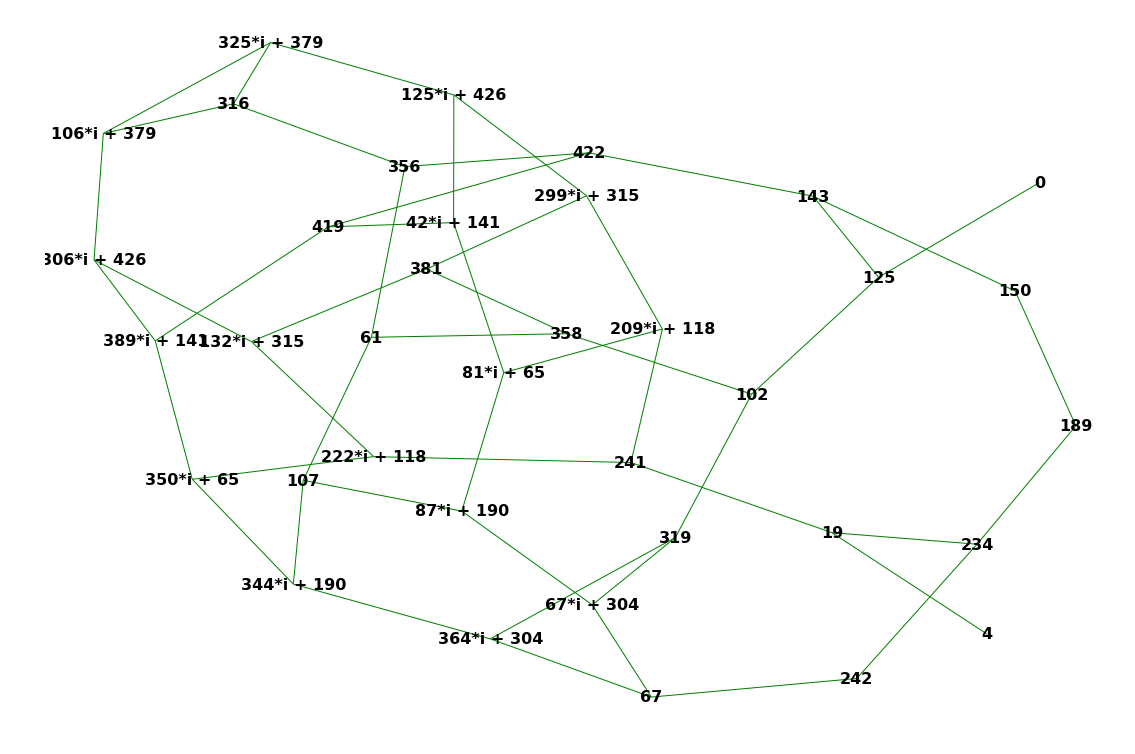

In [9]:
plt.figure(figsize=(15,10))
nx.draw_kamada_kawai(G, with_labels=True, node_size=0, font_size=16, edge_color='green', font_weight='bold')

We can also easily do the same for $\ell=3$:

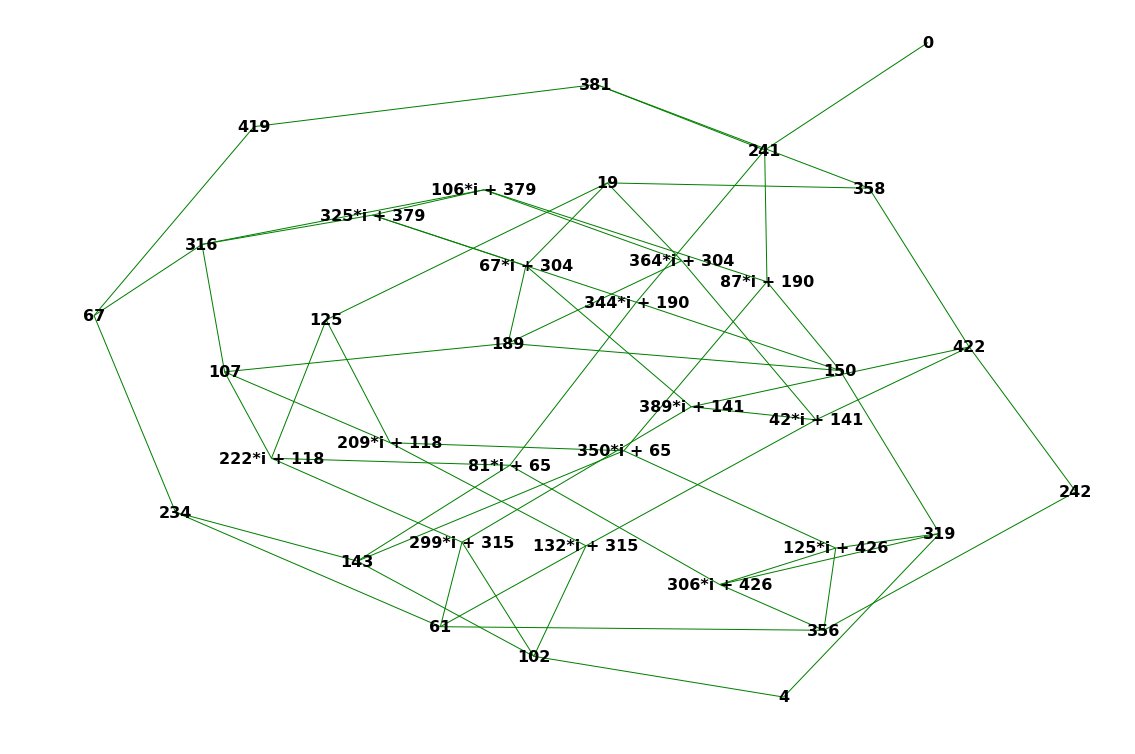

In [10]:
G = nx.Graph()
G.add_nodes_from(js)
l = 3
for j in js:
    add_edges(j, G, l) 
plt.figure(figsize=(15,10))
nx.draw_kamada_kawai(G, with_labels=True, node_size=0, font_size=16, edge_color='green', font_weight='bold')

## Walking through the SIDH protocol
We'll now walk through the protocol as in Section 5 of the paper.

Unfortunately, the paper does not compute $E/\langle P \rangle$ in the same way as Sage (remember that $E/\langle P \rangle$ is defined only up to isomorphism). Therefore we won't observe the exact same parameters as in the paper, but it will be interesting to see if we get the same results as in the paper.

### Setup
We use the same initial parameters as the paper.

In [11]:
a = 329 * i + 423
E = EllipticCurve(K, [0, a, 0, 1, 0]) # We start with the same curve E_a0 as the paper.
PA, QA = E(100*i + 248, 304*i + 199), E(426*i + 394, 51*i + 79) # We use the same base points for A.
PB, QB = E(358*i + 275, 410*i + 104), E(20*i + 185, 281*i + 239) # We use the same base points for B.
assert PA.order() == 16
assert QA.order() == 16
assert PB.order() == 27
assert QB.order() == 27

In [12]:
kA = 11 # We use the same secret key for A.
SA = PA + kA * QA
assert SA.order() == 16

### Public key generation
The first part of the protocol works sequentially as follows. Given a point $P$ of order $\ell^d$ in $E$, we compute $Q=\ell^{d-1}\cdot P$, which has order $\ell$. Associated to $Q$ is an isogeny $\phi: E \to E/\langle Q\rangle$ of degree $\ell$. 

Since $\phi$ is a group homomorphism with kernel $\langle Q\rangle$, we have $0=\phi(Q) = \phi(\ell^{d-1}\cdot P) = \ell^{d-1}\cdot \phi(P)$. Thus, $\phi(P)$ is a point of order $\ell^{d-1}$ in $E/\langle Q \rangle$.

By continuing this process, we can get an isogeny of degree $\ell^d$ in $d$ steps.

Also, remember that we need to keep track of the points $P_B, Q_B$ for Alice and $P_A, Q_A$ for Bob.


First, we write a function implementing the process describe above.

In [13]:
def walk_isogeny_graph_step(E, P, P_other, Q_other, l, d):
    """
    Given `P ∈ E` of order `l**d`, returns a curve `E_new` and a point `P_new` of order `l**(d-1).
    Also returns the image of the points `P_other, Q_other` under the isogeny.
    """
    assert P.order() == l**d
    Q = (l**(d-1)) * P
    phi = E.isogeny(Q)
    E_new = phi.codomain()
    P_new = phi(P)
    assert P_new.order() == l**(d-1)
    P_other_new, Q_other_new = phi(P_other), phi(Q_other)
    
    return E_new, P_new, P_other_new, Q_other_new

Then, we write the loop iterating the step $d$ times.

In [14]:
def walk_isogeny_graph(E, P, P_other, Q_other, l, d):
    for i in range(d):
        E, P, P_other, Q_other = walk_isogeny_graph_step(E, P, P_other, Q_other, l, d)
        d -= 1
        print(f'Step {i}: j-invariant is {E.j_invariant()}')
        
    assert P.is_zero() # At the end of the protocol, P as order l^0 aka P is zero.
    return E, P_other, Q_other

By walking the isogeny graph, Alice effectively computes an isogeny $$\phi_A: E \to E_A$$ of degree $2^{d_A}$. 

Alice's public key $PK_A$ is then the tuple $\left(E_A, \phi_A(P_B), \phi_A(Q_B)\right)$.

In [15]:
PK_A = walk_isogeny_graph(E, SA, PB, QB, 2, 4)

Step 0: j-invariant is 107
Step 1: j-invariant is 344*i + 190
Step 2: j-invariant is 350*i + 65
Step 3: j-invariant is 222*i + 118


We observe that the $j$-invariants of the intermediary curves are the same as in the paper.

Now we can easily do the same for Bob.

In [16]:
kB = 2 # We use the same secret key for A.
SB = PB + kB * QB
assert SB.order() == 27

PK_B = walk_isogeny_graph(E, SB, PA, QA, 3, 3)

Step 0: j-invariant is 106*i + 379
Step 1: j-invariant is 325*i + 379
Step 2: j-invariant is 344*i + 190


Again, we can see that we've walked the same isogeny path as in the paper, even though the curves are not the same. This is because isomorphic curves have the same $j$-invariant.

### Shared secret generation
Given Bob's public key $\phi_B(P_A), \phi_B(Q_A) \in E_B$, Alice can compute $$\phi_B(S_A)=\phi_B(P_A + k_A Q_A) = \phi_B(P_A) + k_A\phi_B(Q_A).$$ Since $\phi_B$ has a kernel of order $3^{d_B}$ and $S_A$ has order $2^{d_A}$, $\phi_B(S_A)$ also has order $2^{d_a}$. (In this example $d_A=4, d_B=3$) 

We can thus use our function `walk_isogeny_graph` to compute the curve $E_B / \langle \phi_B(S_A)\rangle$, whose $j$-invariant is the shared secret.

In [17]:
SA = PK_B[1] + kA * PK_B[2]
shared_curve, _, _ = walk_isogeny_graph(PK_B[0], SA, PK_B[1], PK_B[2], 2, 4)
print(f'Shared secret is {shared_curve.j_invariant()}')

Step 0: j-invariant is 364*i + 304
Step 1: j-invariant is 67
Step 2: j-invariant is 242
Step 3: j-invariant is 234
Shared secret is 234


This output can be compared with Figure 9.

Now we do the same for Bob.

In [18]:
SB = PK_A[1] + kB * PK_A[2]
shared_curve, _, _ = walk_isogeny_graph(PK_A[0], SB, PK_A[1], PK_A[2], 3, 3)
print(f'Shared secret is {shared_curve.j_invariant()}')

Step 0: j-invariant is 299*i + 315
Step 1: j-invariant is 61
Step 2: j-invariant is 234
Shared secret is 234


This output can be compared with Figure 10.

### Hooray! We got the same results as in the paper! (i.e math works 🥳)
(Note that for conciseness, we haven't use some of the tricks shown in the paper to reduce space usage or computational complexity.)

## Putting it all together
The example was a bit convoluted. Let's write clean functions that go through the protocol in it's entirety. They will be useful in a later post about the cryptanalysis of the SIDH protocol.

In [19]:
def generate_private_key(l, d):
    return randint(0, l**d - 1)

In [20]:
def generate_public_key(E, P, Q, P_other, Q_other, sk, l, d):
    S = P + sk * Q
    return walk_isogeny_graph(E, S, P_other, Q_other, l, d)

In [21]:
def generate_share_secret(sk, pk_other, l, d):
    S = pk_other[1] + sk * pk_other[2]
    shared_curve, _, _ = walk_isogeny_graph(pk_other[0], S, pk_other[1], pk_other[2], l, d)
    return shared_curve.j_invariant()

In [22]:
def simulate_protocol(E, PA, QA, PB, QB, lA, dA, lB, dB):
    kA = generate_private_key(lA, dA)
    pk_A = generate_public_key(E, PA, QA, PB, QB, kA, lA, dA)
    kB = generate_private_key(lB, dB)
    pk_B = generate_public_key(E, PB, QB, PA, QA, kB, lB, dB)
    
    shared_A = generate_share_secret(kA, pk_B, lA, dA)
    shared_B = generate_share_secret(kB, pk_A, lB, dB)
    
    if shared_A == shared_B:
        print(f"Same shared secret: {shared_A}")
    else:
        print("Oho...")

In [23]:
simulate_protocol(E, PA, QA, PB, QB, 2, 4, 3, 3)

Step 0: j-invariant is 107
Step 1: j-invariant is 61
Step 2: j-invariant is 356
Step 3: j-invariant is 422
Step 0: j-invariant is 241
Step 1: j-invariant is 381
Step 2: j-invariant is 419
Step 0: j-invariant is 42*i + 141
Step 1: j-invariant is 81*i + 65
Step 2: j-invariant is 209*i + 118
Step 3: j-invariant is 299*i + 315
Step 0: j-invariant is 42*i + 141
Step 1: j-invariant is 389*i + 141
Step 2: j-invariant is 299*i + 315
Same shared secret: 299*i + 315


# Conclusion
That's it for this notebook. We wrote working code that simulates the SIDH protocol! 

As you might have guessed already, the actual SIKE protocol works a bit differently and uses a lot of small optimizations. We'll look at that in a later post. We'll also have a look at the cryptanalysis of SIDH.